# Surface radiation field tools

In this tutorial we demonstrate usage of several tools for checking the implementation of a surface radiation field extension module.

The required atmosphere data files are needed and they can be found in the [Zenodo](https://zenodo.org/record/7094144).

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import os

In [2]:
import xpsi

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.2.2               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 1.4.7
Imported nestcheck version: 0.2.1


In [3]:
from matplotlib import pyplot as plt
plt.rc('font', size=20.0)

## Calculate the specific intensity directly from local variables

In [4]:
# keV (local comoving frame)
E = np.logspace(-2.0, 0.5, 1000, base=10.0)

# cos(angle to local surface normal in comoving frame)
mu = np.ones(1000) * 0.5

# log10(eff. temperature [K]) and log10(local eff. gravity [cm/s^2])
local_vars = np.array([[6.11, 13.8]]*1000)

In [5]:
#xpsi.surface_radiation_field?

In [6]:
#xpsi.surface_radiation_field.intensity?

### Isotropic blackbody

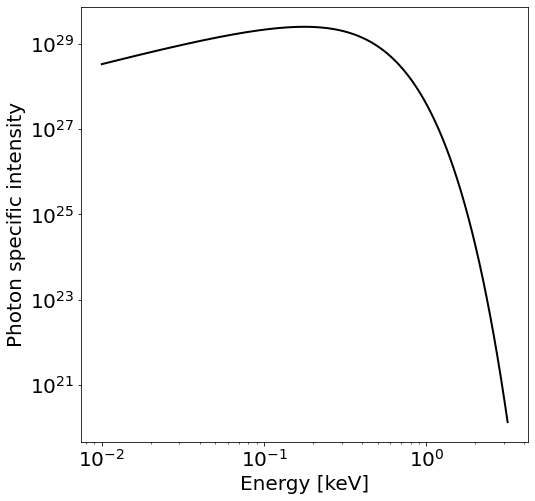

In [7]:
plt.figure(figsize=(8,8))

BB_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars, atmos_extension="BB", # NB: isotropic blackbody
                                              region_extension='elsewhere', numTHREADS=2)

plt.plot(E, BB_I, 'k-', lw=2.0)

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Photon specific intensity')
_ = ax.set_xlabel('Energy [keV]')

### Polarized non-isotropic burst blackbody

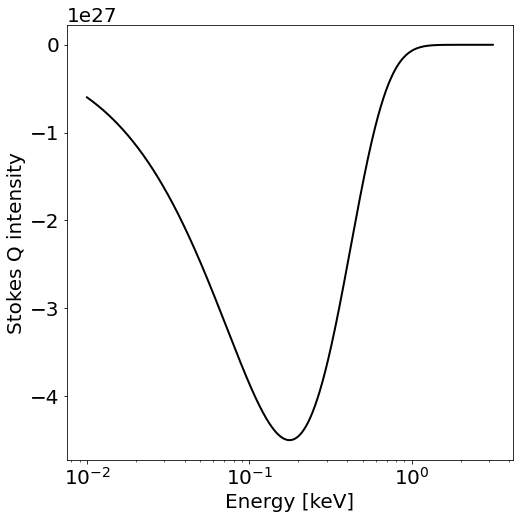

In [8]:
#Note: This block only works for X-PSI versions above 2.2.0.

plt.figure(figsize=(8,8))

BB_Q = xpsi.surface_radiation_field.intensity(E, mu, local_vars, atmos_extension="Pol_BB_Burst", stokesQ=1,
                                              region_extension='hot', numTHREADS=2)

plt.plot(E, BB_Q, 'k-', lw=2.0)

ax = plt.gca()
ax.set_xscale('log')
ax.set_ylabel('Stokes Q intensity')
_ = ax.set_xlabel('Energy [keV]')

### Numerical atmosphere

Let's check out a numerical atmosphere (this code you typically find in a custom photosphere class). The numerical atmospheres loaded here were generated by the NSX atmosphere code ([Ho & Lai (2001)](https://ui.adsabs.harvard.edu/abs/2001MNRAS.327.1081H/abstract); [Ho & Heinke (2009)](https://ui.adsabs.harvard.edu/link_gateway/2009Natur.462...71H/doi:10.1038/nature08525)), courtesy of W.C.G. Ho for NICER modeling efforts. One of these atmospheres (fully-ionized hydrogen; Ho & Lai 2001) was used in [Riley et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...887L..21R/abstract); also see [Bogdanov et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...914L..15B/abstract) and [Riley et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...918L..27R/abstract). For this tutorial we need the data files `nsx_H_v171019.out` and `nsx_He_v170925.out` that can be found in [Zenodo](https://zenodo.org/record/7094145). The repository includes also a fully-ionized hydrogen data file with an extended surface gravity grid (`nsx_H_v200804.out`), which was used in [Riley et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...918L..27R/abstract), but not in this tutorial.

In [9]:
def preload(path, size):
    NSX = np.loadtxt(path, dtype=np.double)
    logT = np.zeros(size[0])
    logg = np.zeros(size[1])
    _mu = np.zeros(size[2]) # use underscore to bypass errors with the other mu array
    logE = np.zeros(size[3])

    reorder_buf = np.zeros(size)

    index = 0
    for i in range(reorder_buf.shape[0]):
        for j in range(reorder_buf.shape[1]):
            for k in range(reorder_buf.shape[3]):
                for l in range(reorder_buf.shape[2]):
                    logT[i] = NSX[index,3]
                    logg[j] = NSX[index,4]
                    logE[k] = NSX[index,0]
                    _mu[reorder_buf.shape[2] - l - 1] = NSX[index,1]
                    reorder_buf[i,j,reorder_buf.shape[2] - l - 1,k] = 10.0**(NSX[index,2])
                    index += 1

    buf = np.zeros(np.prod(reorder_buf.shape))

    bufdex = 0
    for i in range(reorder_buf.shape[0]):
        for j in range(reorder_buf.shape[1]):
            for k in range(reorder_buf.shape[2]):
                for l in range(reorder_buf.shape[3]):
                    buf[bufdex] = reorder_buf[i,j,k,l]; bufdex += 1

    atmosphere = (logT, logg, _mu, logE, buf)
    
    return atmosphere

In [10]:
H_fully = preload('../../examples/examples_modeling_tutorial/model_data/nsx_H_v171019.out',
                    size=(35, 11, 67, 166))

In [11]:
He_fully = preload('../../examples/examples_modeling_tutorial/model_data/nsx_He_v170925.out',
                      size=(29, 11, 67, 166))

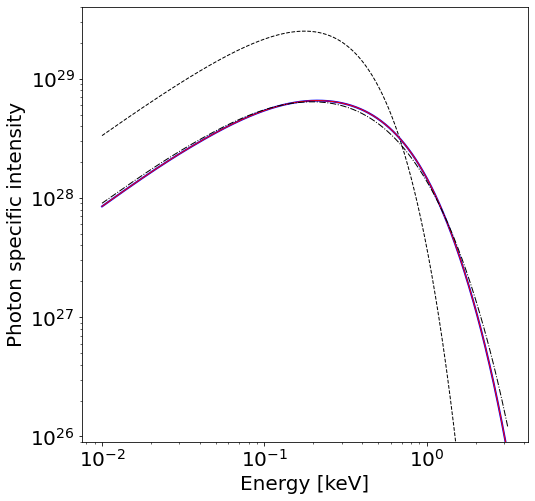

In [12]:
plt.figure(figsize=(8,8))

plt.plot(E, BB_I, 'k--', lw=1.0)

hot_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                               atmosphere=H_fully,
                                               region_extension='hot',
                                               atmos_extension="Num4D",
                                               numTHREADS=2)

plt.plot(E, hot_I, 'b-', lw=2.0)

elsewhere_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                     atmosphere=H_fully,
                                                     region_extension='elsewhere',
                                                     atmos_extension="Num4D",
                                                     numTHREADS=2)

plt.plot(E, elsewhere_I, 'r-', lw=1.0)

He_fully_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                     atmosphere=He_fully,
                                                     region_extension='hot',
                                                     atmos_extension="Num4D",
                                                     numTHREADS=2)

plt.plot(E, He_fully_I, 'k-.', lw=1.0)

ax = plt.gca()
ax.set_yscale('log')
ax.set_ylim([9.0e25,4.0e29])
ax.set_xscale('log')
ax.set_ylabel('Photon specific intensity')
_ = ax.set_xlabel('Energy [keV]')

This behaviour is typical for an isotropic blackbody radiation field with temperature $T$ in comparison to a radiation field emergent from a (non-magnetic, fully-ionized) geometrically-thin H/He atmosphere with effective temperature $T$.

Let's plot the angular dependence:

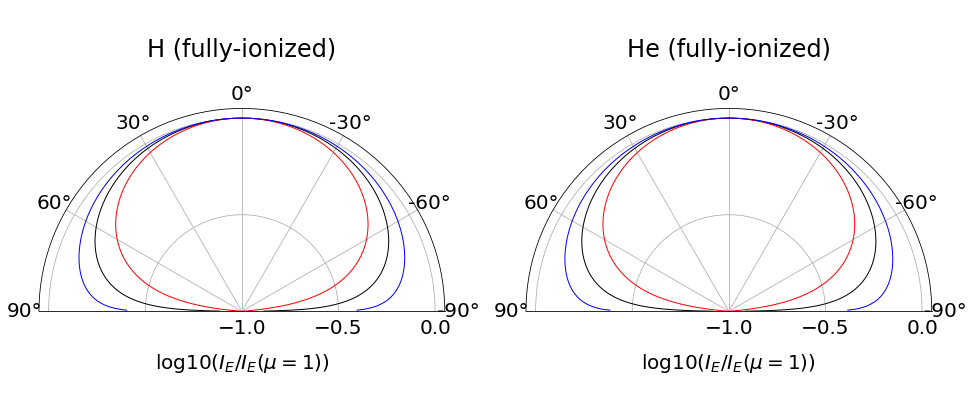

In [13]:
# keV (local comoving frame)
E = np.ones(1000) * 0.2

# cos(angle to local surface normal in comoving frame)
mu = np.linspace(0.01,1.0,1000)

fig = plt.figure(figsize=(16,8))

# Hydrogen

ax = fig.add_subplot(121, projection='polar')

ax.set_theta_direction(1)
ax.set_thetamin(-90.0)
ax.set_thetamax(90.0)

# log10(eff. temperature [K]) and log10(local eff. gravity [cm/s^2])
local_vars = np.array([[6.0, 13.8]]*1000)

H_fully_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                   atmosphere=H_fully,
                                                   region_extension='hot',
                                                   atmos_extension="Num4D",
                                                   numTHREADS=2)

ax.plot(np.arccos(mu), np.log10(H_fully_I/np.max(H_fully_I)), 'k-', lw=1.0)
ax.plot(-np.arccos(mu), np.log10(H_fully_I/np.max(H_fully_I)), 'k-', lw=1.0)

# log10(eff. temperature [K]) and log10(local eff. gravity [cm/s^2])
local_vars = np.array([[5.5, 13.8]]*1000)

H_fully_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                   atmosphere=H_fully,
                                                   region_extension='hot',
                                                   atmos_extension="Num4D",
                                                   numTHREADS=2)


ax.plot(np.arccos(mu), np.log10(H_fully_I/np.max(H_fully_I)), 'r-', lw=1.0)
ax.plot(-np.arccos(mu), np.log10(H_fully_I/np.max(H_fully_I)), 'r-', lw=1.0)

# log10(eff. temperature [K]) and log10(local eff. gravity [cm/s^2])
local_vars = np.array([[6.5, 13.8]]*1000)

H_fully_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                   atmosphere=H_fully,
                                                   region_extension='hot',
                                                   atmos_extension="Num4D",
                                                   numTHREADS=2)


ax.plot(np.arccos(mu), np.log10(H_fully_I/np.max(H_fully_I)), 'b-', lw=1.0)
ax.plot(-np.arccos(mu), np.log10(H_fully_I/np.max(H_fully_I)), 'b-', lw=1.0)

ax.set_rmax(0.05)
ax.set_rmin(-1)
ax.set_theta_zero_location("N")
ax.set_rticks([-1.0,-0.5, 0.0])
ax.set_xlabel('log10$(I_E/I_E(\mu=1))$')
ax.xaxis.set_label_coords(0.5, 0.15)
_ = ax.set_title('H (fully-ionized)', pad=-50)

# Helium

ax = fig.add_subplot(122, projection='polar')

ax.set_theta_direction(1)
ax.set_thetamin(-90.0)
ax.set_thetamax(90.0)

# log10(eff. temperature [K]) and log10(local eff. gravity [cm/s^2])
local_vars = np.array([[6.0, 13.8]]*1000)

He_fully_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                     atmosphere=He_fully,
                                                     region_extension='hot',
                                                     atmos_extension="Num4D",
                                                     numTHREADS=2)

ax.plot(np.arccos(mu), np.log10(He_fully_I/np.max(He_fully_I)), 'k-', lw=1.0)
ax.plot(-np.arccos(mu), np.log10(He_fully_I/np.max(He_fully_I)), 'k-', lw=1.0)

# log10(eff. temperature [K]) and log10(local eff. gravity [cm/s^2])
local_vars = np.array([[5.5, 13.8]]*1000)

He_fully_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                     atmosphere=He_fully,
                                                     region_extension='hot',
                                                     atmos_extension="Num4D",
                                                     numTHREADS=2)

ax.plot(np.arccos(mu), np.log10(He_fully_I/np.max(He_fully_I)), 'r-', lw=1.0)
ax.plot(-np.arccos(mu), np.log10(He_fully_I/np.max(He_fully_I)), 'r-', lw=1.0)

# log10(eff. temperature [K]) and log10(local eff. gravity [cm/s^2])
local_vars = np.array([[6.5, 13.8]]*1000)

He_fully_I = xpsi.surface_radiation_field.intensity(E, mu, local_vars,
                                                     atmosphere=He_fully,
                                                     region_extension='hot',
                                                     atmos_extension="Num4D",
                                                     numTHREADS=2)

ax.plot(np.arccos(mu), np.log10(He_fully_I/np.max(He_fully_I)), 'b-', lw=1.0)
ax.plot(-np.arccos(mu), np.log10(He_fully_I/np.max(He_fully_I)), 'b-', lw=1.0)

ax.set_rmax(0.05)
ax.set_rmin(-1)
ax.set_theta_zero_location("N")
ax.set_rticks([-1.0,-0.5, 0.0])
ax.set_xlabel('log10$(I_E/I_E(\mu=1))$')
ax.xaxis.set_label_coords(0.5, 0.15)
_ = ax.set_title('He (fully-ionized)', pad=-50)

## Calculate the specific intensity indirectly via global variables

We can also calculate intensities by specifying spacetime coordinates at the surface and values for some set of global variables that control the radiation field.

In [14]:
#xpsi.surface_radiation_field.intensity_from_globals?

In [15]:
# unimportant here; just use strict bounds
bounds = dict(mass = (None, None), 
              radius = (None, None),
              distance = (None, None),
              cos_inclination = (None, None))

spacetime = xpsi.Spacetime(bounds, dict(frequency = 1.0/(4.87e-3))) # J0030 spin

Creating parameter:
    > Named "frequency" with fixed value 2.053e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e-03, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [1.000e+00, 2.000e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-02, 3.000e+01].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [-1.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


In [16]:
# keV (local comoving frame)
E = np.logspace(-2.0, 0.5, 1000, base=10.0)

# cos(angle to local surface normal in comoving frame)
mu = np.ones(1000) * 0.5

In [17]:
colatitude = np.ones(1000) * 1.0 # radians
azimuth = np.zeros(1000)
phase = np.zeros(1000)

#The general format of the default global variables:
#np.array([self['p__super_colatitude'],
#self['p__phase_shift'] * 2.0 * math.pi,
#self['p__super_radius'],
#self['p__cede_colatitude'],
#self['p__phase_shift'] * 2.0 * math.pi - self['p__cede_azimuth'],
#self['p__cede_radius'],
#self['s__super_colatitude'],
#(self['s__phase_shift'] + 0.5) * 2.0 * math.pi,
#self['s__super_radius'],
#self['s__cede_colatitude'],
#(self['s__phase_shift'] + 0.5) * 2.0 * math.pi - self['s__cede_azimuth'],
#self['s__cede_radius'],
#self['p__super_temperature'],
#self['p__cede_temperature'],
#self['s__super_temperature'],
#self['s__cede_temperature']])

#For a star with uniform temperature:
global_vars = np.array([0.0,
                        0.0,
                        np.pi,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        6.11,
                        0.0,
                        0.0,
                        0.0]) 

In [18]:
spacetime.params

[Spin frequency [Hz] = 2.053e+02,
 Gravitational mass [solar masses],
 Coordinate equatorial radius [km],
 Earth distance [kpc],
 Cosine of Earth inclination to rotation axis]

In [19]:
spacetime['radius'] = 12.0
spacetime['mass'] = 1.4
# we do not need the observer coordinates (typically handled
# by xpsi.Spacetime instances) to compute effective gravity so
# no need to set values

# the first 5 arguments are 1D arrays that specific a point sequence in the
# joint space of surface spacetime coordinates, energy, and angle
# if you have a set of such points that does not conform readily
# to a 1D array, write a custom wrapper to handle the structure
# in your point set
I_E = xpsi.surface_radiation_field.intensity_from_globals(E,
                                                          mu,
                                                          colatitude,
                                                          azimuth,
                                                          phase,
                                                          global_vars,       # -> eff. temp.
                                                          spacetime.R,       # -> eff. grav.
                                                          spacetime.zeta,    # -> eff. grav.
                                                          spacetime.epsilon, # -> eff. grav.
                                                          atmosphere=H_fully,
                                                          atmos_extension="Num4D",
                                                          numTHREADS=2)

Note that only the `hot` region extension is invoked here.

Let's plot the spectrum and also the spectrum generated by declaring the effective gravity directly above:

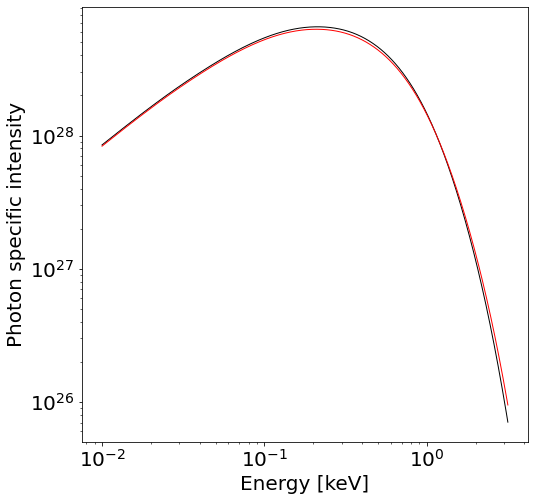

In [20]:
plt.figure(figsize=(8,8))

plt.plot(E, hot_I, 'k-', lw=1.0)
plt.plot(E, I_E, 'r-', lw=1.0)

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Photon specific intensity')
_ = ax.set_xlabel('Energy [keV]')

## Comparing the pulse profiles from blackbody emission and numerical atmospheres

### First some plotting methods for figures

### Defining the spacetime

In [21]:
bounds = dict(distance = (None, None),                   # Default bounds for (Earth) distance
                mass = (1.0, 3.0),                       # Default bounds for mass 
                radius = (None, None),                   # Default bounds for equatorial radius
                cos_inclination = (None, None))          # Default bounds for (Earth) inclination to rotation axis

values = dict(frequency=300.0 )                          # Fixed spin frequency

spacetime = xpsi.Spacetime(bounds=bounds, values=values)

Creating parameter:
    > Named "frequency" with fixed value 3.000e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [1.000e+00, 2.000e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-02, 3.000e+01].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [-1.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


### Constructing the hot regions with blackbody emission

In [22]:
bounds_hotregion = dict(super_colatitude = (None, None),
              super_radius = (None, None),
              phase_shift = (0.0, 0.1),
              super_temperature = (None, None))

# a simple circular, simply-connected spot
primary_BB = xpsi.HotRegion(bounds=bounds_hotregion,
                            values={}, # no initial values and no derived/fixed
                            symmetry=True,
                            omit=False,
                            cede=False,
                            concentric=False,
                            sqrt_num_cells=32,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=64,
                            num_leaves=100,
                            num_rays=200,
                            do_fast=False,
                            atm_ext="BB",#default blackbody, other options: "Num4D" or "user"                         
                            prefix='p') # unique prefix needed because >1 instance

# overlap of an omission region and
# and a radiating super region
secondary_BB = xpsi.HotRegion(bounds=bounds_hotregion,
                              values={}, # no fixed/derived variables
                              symmetry=True,
                              omit=False,
                              cede=False,
                              concentric=False,
                              sqrt_num_cells=32,
                              min_sqrt_num_cells=10,
                              max_sqrt_num_cells=100,
                              num_leaves=100,
                              num_rays=200,
                              do_fast=False,
                              is_secondary=True,
                              atm_ext="BB",#default blackbody, other options: "Num4D" or "user"               
                              prefix='s')

from xpsi import HotRegions
hot_BB = HotRegions((primary_BB, secondary_BB))

Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000e-01].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "super_temperature" with bounds [3.000e+00, 7.600e+00].
    > log10(superseding region effective temperature [K]).
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000

### Constructing the photosphere for the hot regions with blackbody emission

In [23]:
class CustomPhotosphere_BB(xpsi.Photosphere):
    """ Implement method for imaging."""
    @property
    def global_variables(self):

        return np.array([self['p__super_colatitude'],
                          self['p__phase_shift'] * 2.0 * math.pi,
                          self['p__super_radius'],
                          0.0, #self['p__cede_colatitude'],
                          0.0, #self['p__phase_shift'] * 2.0 * math.pi - self['p__cede_azimuth'],
                          0.0, #self['p__cede_radius'],
                          self['s__super_colatitude'],
                          (self['s__phase_shift'] + 0.5) * 2.0 * math.pi,
                          self['s__super_radius'],
                          0.0, #self['s__cede_colatitude'],
                          0.0, #(self['s__phase_shift'] + 0.5) * 2.0 * math.pi - self['s__cede_azimuth'],
                          0.0, #self['s__cede_radius'],
                          self['p__super_temperature'],
                          0.0, #self['p__cede_temperature'],
                          self['s__super_temperature'],
                          0.0]) #self['s__cede_temperature']])  

photosphere_BB = CustomPhotosphere_BB(hot = hot_BB, elsewhere = None,
                                      values=dict(mode_frequency = spacetime['frequency']))
photosphere_BB

Creating parameter:
    > Named "mode_frequency" with fixed value 3.000e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].


Free parameters
---------------
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_colatitude: The colatitude of the centre of the superseding region [radians].
s__super_radius: The angular radius of the (circular) superseding region [radians].
s__super_temperature: log10(superseding region effective temperature [K]).

Derived/fixed parameters
------------------------
mode_frequency: Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].

### Constructing the star with the blackbody photosphere

In [24]:
star_BB = xpsi.Star(spacetime = spacetime, photospheres = photosphere_BB)
star_BB.params

[Gravitational mass [solar masses],
 Coordinate equatorial radius [km],
 Earth distance [kpc],
 Cosine of Earth inclination to rotation axis,
 The phase of the hot region, a periodic parameter [cycles],
 The colatitude of the centre of the superseding region [radians],
 The angular radius of the (circular) superseding region [radians],
 log10(superseding region effective temperature [K]),
 The phase of the hot region, a periodic parameter [cycles],
 The colatitude of the centre of the superseding region [radians],
 The angular radius of the (circular) superseding region [radians],
 log10(superseding region effective temperature [K])]

In [25]:
Star_params = [1.4,          # Mass
               12.0,         # Radius
               0.2,          # Distance
               np.cos(1.25), # Cos(inclination)
               0.0,          # phase of primary region
               1.0,          # Colatitute of primary region
               0.075,        # Angular radius of primary region
               6.0,          # Temperature of primary region
               0.025,        # phase of secondary region
               np.pi - 1.0,  # Colatitute of secondary region
               0.2,          # Angular radius of secondary region
               6.0,]         # Temperature of secondary region
star_BB(Star_params)
star_BB.params

[Gravitational mass [solar masses] = 1.400e+00,
 Coordinate equatorial radius [km] = 1.200e+01,
 Earth distance [kpc] = 2.000e-01,
 Cosine of Earth inclination to rotation axis = 3.153e-01,
 The phase of the hot region, a periodic parameter [cycles] = 0.000e+00,
 The colatitude of the centre of the superseding region [radians] = 1.000e+00,
 The angular radius of the (circular) superseding region [radians] = 7.500e-02,
 log10(superseding region effective temperature [K]) = 6.000e+00,
 The phase of the hot region, a periodic parameter [cycles] = 2.500e-02,
 The colatitude of the centre of the superseding region [radians] = 2.142e+00,
 The angular radius of the (circular) superseding region [radians] = 2.000e-01,
 log10(superseding region effective temperature [K]) = 6.000e+00]

### Constructing the hot regions with emission from a numerical atmosphere

In [26]:
# a simple circular, simply-connected spot
primary_num4D = xpsi.HotRegion(bounds=bounds_hotregion,
                            values={}, # no initial values and no derived/fixed
                            symmetry=True,
                            omit=False,
                            cede=False,
                            concentric=False,
                            sqrt_num_cells=32,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=64,
                            num_leaves=100,
                            num_rays=200,
                            do_fast=False,
                            atm_ext="Num4D",#default blackbody, other options: "Num4D" or "user"                         
                            prefix='p') # unique prefix needed because >1 instance

# overlap of an omission region and
# and a radiating super region
secondary_num4D = xpsi.HotRegion(bounds=bounds_hotregion,
                              values={}, # no fixed/derived variables
                              symmetry=True,
                              omit=False,
                              cede=False,
                              concentric=False,
                              sqrt_num_cells=32,
                              min_sqrt_num_cells=10,
                              max_sqrt_num_cells=100,
                              num_leaves=100,
                              num_rays=200,
                              do_fast=False,
                              is_secondary=True,
                              atm_ext="Num4D",#default blackbody, other options: "Num4D" or "user"               
                              prefix='s')

hot_Num4D = HotRegions((primary_num4D, secondary_num4D))

Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000e-01].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "super_temperature" with bounds [3.000e+00, 7.600e+00].
    > log10(superseding region effective temperature [K]).
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000

### Constructing the photosphere for the hot regions with emission from a numerical atmosphere

In [27]:
class CustomPhotosphere_num(xpsi.Photosphere):
    """ A photosphere extension to preload the numerical atmosphere NSX. """

    @xpsi.Photosphere.hot_atmosphere.setter
    def hot_atmosphere(self, path):
        
        size=(35, 14, 67, 166)
        # USING THE PRELOAD FUNCTION DEFINED ABOVE
        self._hot_atmosphere = preload(path, size)

                
photosphere_num = CustomPhotosphere_num(hot = hot_Num4D,
                                        elsewhere = None,
                                        values=dict(mode_frequency = spacetime['frequency']))

photosphere_num

Creating parameter:
    > Named "mode_frequency" with fixed value 3.000e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].


Free parameters
---------------
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_colatitude: The colatitude of the centre of the superseding region [radians].
s__super_radius: The angular radius of the (circular) superseding region [radians].
s__super_temperature: log10(superseding region effective temperature [K]).

Derived/fixed parameters
------------------------
mode_frequency: Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].

### Pre-loading the numerical atmosphere by providing the model table (NSX)

In [28]:
photosphere_num.hot_atmosphere = '../../examples/examples_modeling_tutorial/model_data/nsx_H_v200804.out' 

### Constructing the star with emission from a numerical atmosphere

In [29]:
star_num4D = xpsi.Star(spacetime = spacetime, photospheres = photosphere_num)
star_num4D(Star_params)  # Same parameters as the blackbody star
star_num4D.params

[Gravitational mass [solar masses] = 1.400e+00,
 Coordinate equatorial radius [km] = 1.200e+01,
 Earth distance [kpc] = 2.000e-01,
 Cosine of Earth inclination to rotation axis = 3.153e-01,
 The phase of the hot region, a periodic parameter [cycles] = 0.000e+00,
 The colatitude of the centre of the superseding region [radians] = 1.000e+00,
 The angular radius of the (circular) superseding region [radians] = 7.500e-02,
 log10(superseding region effective temperature [K]) = 6.000e+00,
 The phase of the hot region, a periodic parameter [cycles] = 2.500e-02,
 The colatitude of the centre of the superseding region [radians] = 2.142e+00,
 The angular radius of the (circular) superseding region [radians] = 2.000e-01,
 log10(superseding region effective temperature [K]) = 6.000e+00]

### Plotting the pulse profile of the two stars for comparison

In [30]:
# Defining the energy range to use
energies = np.logspace(-1.0, np.log10(3.0), 128, base=10.0)

In [31]:
star_BB['cos_inclination'] = np.cos(2.0)
star_BB.update()
photosphere_BB.integrate(energies, threads=1) # the number of OpenMP threads to use


In [32]:
star_num4D['cos_inclination'] = np.cos(2.0)
star_num4D.update()
photosphere_num.integrate(energies, threads=1) # the number of OpenMP threads to use


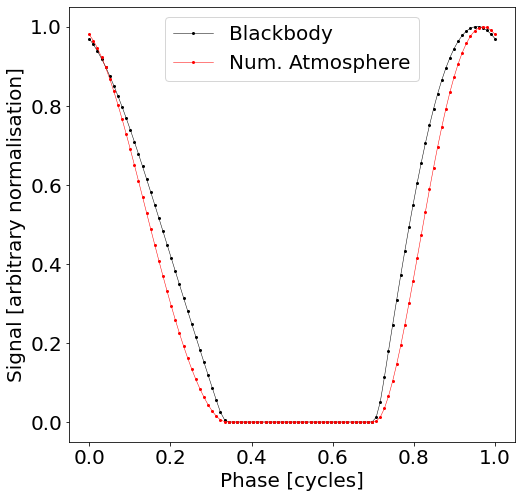

In [33]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_ylabel('Signal [arbitrary normalisation]')
ax.set_xlabel('Phase [cycles]')
    
tempY = np.sum(photosphere_BB.signal[0][0], axis=0)
ax.plot(hot_BB.phases_in_cycles[0], tempY/np.max(tempY), 
        'o-', color='k', lw=0.5, markersize=2,
         label='Blackbody')

    
tempY = np.sum(photosphere_num.signal[0][0], axis=0)
ax.plot(hot_Num4D.phases_in_cycles[0], tempY/np.max(tempY), 'o-', color='r', lw=0.5, markersize=2,
         label='Num. Atmosphere')

ax.legend()